# CISC 873 Data Mining Competition 5 (Anti-cancer activity prediction)

## Questions

### Based on the provided template, describe the format of the input file (sdf file).

- The SDF (Structure Data File) File is a text file that represents the molecular structure of a chemical compound. 
- It contains information about the atoms and bonds in the molecule, as well as additional properties.
- Each compound is represented as a graph, with atoms representing nodes and bonds as edges.

### What are the input tensors to the neural network model (their meaning, not just symbol)? What is each of their dims and their meaning (e.g. batch_size)?

The input tensors to the neural network model are:

- Nodes Feature: the nodes of the chemical compound in the tokenized form.
  - The shape of each batch is (batch_size * max_len).
    - batch_size is the number of samples in the batch 
    - max_len is the length of tokenized nodes with padding.

- Edge Feature: the relation between atoms(nodes).
  - The shape of each batch is (sum_of_all_edges, 2).
    - The sum_of_all_edges represents the sum of the edges of each sample of the batch_size.

- node2graph Feature: the segmented mean and information about segmented ids.
  - The shape of each batch is (batch_size * max_len).

### For each dim of gnn_out, what does it symbolize? For each dim of avg, what does it symbolize?

- gnn_out: A tensor of shape [batch_size, hidden_size], where hidden_size is the size of the hidden layer in the GCN.
- avg: A tensor of shape [batch_size], where each entry is the average of the hidden representations of the atoms in the corresponding molecule.

### What is the difference between segment_mean and tf.reduce_mean? For each dim of pred, what does it symbolize?

- segment_mean: A function that computes the mean of a tensor along a specific segment axis.
- tf.reduce_mean: A function that computes the mean of a tensor over all axes.
- The difference between segment_mean and tf.reduce_mean is that segment_mean allows you to compute the mean of a tensor along a specific segment axis, while tf.reduce_mean computes the mean of a tensor over all axes.

- pred: A tensor of shape [batch_size], where each entry is the predicted label of the corresponding molecule.

### What is the motivation/theory/idea to use multiple gcn layers comparing to just one? How many layers were used in the template?

The motivation to use multiple GCN layers is that it allows the model to learn more complex relationships between the atoms in a molecule. Each GCN layer learns a different representation of the atoms, and the representations from each layer are combined to produce the final prediction.

The template uses 4 GCN layers as shown in the documentation defualt.

## Overview

### Define the problem

The problem is to predict the activity of chemical compounds against non-small cell lung cancer based on their molecular structure.

### What is the input?

 The input is a set of molecular graphs represented as nodes (atoms) and edges (bonds).

### What is the output?

The output is a binary label indicating whether the compound is positive or negative for non-small cell lung cancer.

### What data mining function is required?

The data mining function required is a graph neural network that can learn to extract relevant features from the molecular graphs and predict the activity of the compounds.

### What could be the challenges?

The challenges include:
- dealing with the complex and variable structure of the molecular graphs
- handling the imbalance between positive and negative samples
- tuning the hyperparameters of the graph neural network.

### What is the impact?

The impact of solving this problem is that it can lead to the discovery of new chemical compounds with potential anticancer activity and accelerate the drug discovery process.

### What is an ideal solution?

The ideal solution would be a graph neural network that can accurately predict the activity of chemical compounds against non-small cell lung cancer based on their molecular structure. The model should be robust to different molecular structures, generalize well to new compounds, and have good interpretability to facilitate the discovery of new drugs.

---

***

## Imports Libraries

### - Common Libraries

In [ ]:
!pip install -U networkx
!pip install -U tf2_gnn

import pandas as pd 
import numpy as np
import random
from tqdm.notebook import tqdm
from math import ceil
from datetime import datetime
from collections import Counter

import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
%matplotlib inline

seed = 72
np.random.seed(seed)
random.seed(seed)

### - Scikit-Learn

In [2]:
import sklearn
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

### Tensorflow

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import Model, backend
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense, Embedding, Dropout
from tensorflow.keras.utils import plot_model
from tf2_gnn.layers.gnn import GNN, GNNInput
from tensorflow.math import segment_mean

## Data

### Read SDF format data (structured-data format)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# google drive data path
data_path = '/content/drive/My Drive/Comp 4'

In [6]:
# kaggle data path
# data_path = '/kaggle/input/cisc873-dm-w23-a6'

In [7]:
# Function to read an SDF file and extract its contents
def read_sdf(file):
    # Open the file in read mode and read its contents
    with open(file, 'r') as rf:
        content = rf.read()
    # Split the contents into individual samples
    samples = content.split('$$$$')
    
    # Function to parse a single sample
    def parse_sample(s):
        # Split the sample into individual lines
        lines = s.splitlines()
        links = []
        nodes = []
        label = 0
        # Iterate over the lines in the sample
        for line in lines:
            # Check if the line contains the label value
            if line.strip() == '1.0':
                label = 1
            if line.strip() == '-1.0':
                label = 0
            # Check if the line contains a node
            if line.startswith('    '):
                feature = line.split()
                node = feature[3]
                nodes.append(node)
            # Check if the line contains an edge
            elif line.startswith(' '):
                lnk = line.split()
                # Create a tuple representing the edge and add it to the list of links
                # Note: the edge is represented as (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes):
                    links.append((
                        int(lnk[0])-1, 
                        int(lnk[1])-1, # zero-based index
                        # int(lnk[2]) ignore edge weight
                    ))
        # Return the nodes, links, and label as a tuple
        return nodes, np.array(links), label
    
    # Parse each sample and return a list of tuples representing the nodes, links, and label for each sample
    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0]

In [8]:
# read training data
training_set = read_sdf(f'{data_path}/train.sdf')

  0%|          | 0/25024 [00:00<?, ?it/s]

In [9]:
# read testing data
testing_set  = read_sdf(f'{data_path}/test_x.sdf')

  0%|          | 0/12326 [00:00<?, ?it/s]

### Split Data
split data to train and validation

In [10]:
# I will split the data into train and validation in the fitting function below.
# because I will need to upsample the data after.
# and I will need the whole training set again.
# training_set, validation_set = train_test_split(training_set, test_size=0.15)

In [11]:
# print(training_set[0])

## Visualizing/Inspecting a Sample

In [12]:
# Create a colormap with 50 different colors
colors = cm.rainbow(np.linspace(0, 1, 50))

# Function to visualize a single sample
def visualize(sample):
    # Create an empty graph object
    graph = nx.Graph()
    # Get the list of nodes and edges for the sample
    nodes = sample[0]
    edges = sample[1]
    
    # Initialize dictionaries to map nodes to labels and colors
    labeldict={}
    node_color=[]
    # Iterate over the nodes in the sample
    for index, node in enumerate(nodes):
        # Add the node to the graph and map its index to its label
        graph.add_node(index)
        labeldict[index] = node
        # Choose a color for the node based on its hash value
        color = hash(node) % len(colors)
        node_color.append(colors[color])

    # Iterate over the edges in the sample and add them to the graph
    for edge in edges:
        graph.add_edge(edge[0], edge[1])
        
    # Draw the graph and display it
    nx.draw(graph, labels=labeldict, with_labels=True, node_color=node_color)
    plt.show()
    
    # Return the graph object
    return graph

#### Example

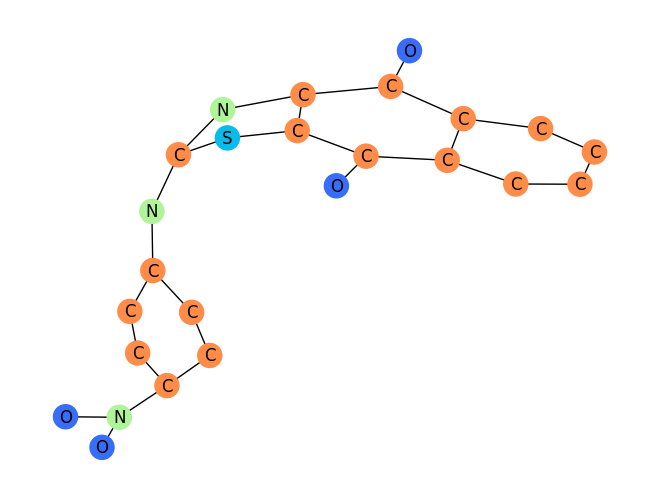

In [13]:
# Clear the current figure
plt.clf()

# Visualize the first sample in the training set
visualize(training_set[0])

#### Plot Data Balance

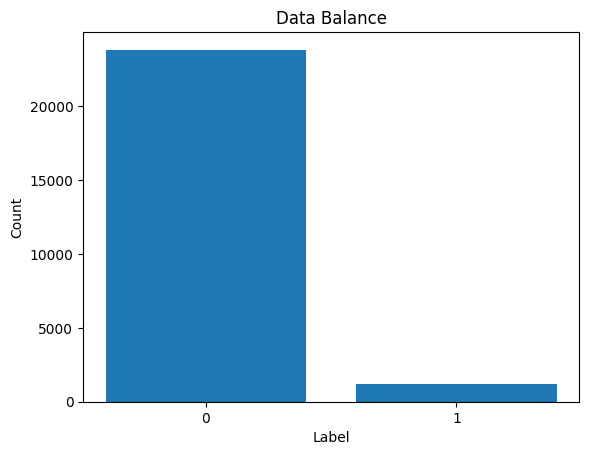

In [14]:
# Extract the labels of all samples in the training set
all_labels = [sample[2] for sample in training_set]

# Count the number of occurrences of each label
unique, counts = np.unique(all_labels, return_counts=True)

# Create a bar chart to visualize the data balance
# Create a bar chart with the unique labels as the x-axis and the corresponding counts as the y-axis
plt.bar(unique, counts)

# Set the x-ticks to be the unique labels
plt.xticks(unique)

# Set the x- and y-axis labels and the chart title
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Data Balance')

# Display the chart
plt.show()

It is very unbalanced dataset

## Preprocessing:

In [15]:
# Extract all nodes from the training set
all_nodes = [s[0] for s in training_set]

# Define the maximum vocabulary size to be the number of elements in the periodic table
max_vocab = 118

# Find the maximum and minimum lengths of nodes in the training set
min_len = min([len(x) for x in all_nodes])
max_len = max([len(x) for x in all_nodes])

# Print the maximum and minimum lengths of nodes in the training set
print(f'Min Len of chemical compound: {min_len}')
print(f'Max Len of chemical compound: {max_len}')

# Create a tokenizer and fit it on the nodes in the training set
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(all_nodes)

Min Len of chemical compound: 3
Max Len of chemical compound: 223


### Create Batches

In [16]:
def prepare_single_batch(samples):
    # Extract the nodes from the samples and tokenize them
    sample_nodes = [sample[0] for sample in samples]
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)
    # Pad the node sequences to the same length
    sample_nodes = pad_sequences(sample_nodes, padding='post')
    # Get the maximum length of the node sequences
    max_nodes_len = np.shape(sample_nodes)[1]
    
    # Extract the edges from the samples and concatenate them
    edges = [sample[1] + index * max_nodes_len for index, sample in enumerate(samples)]
    edges = [edge for edge in edges if len(edge) > 0]
    
    # Create a list of indices that maps each node to its corresponding graph
    node_to_graph = [[index] * max_nodes_len for index in range(len(samples))]
    
    # Flatten the node and edge lists and create a separate list that maps each node to its corresponding graph
    all_nodes = np.reshape(sample_nodes, -1)
    all_edges = np.concatenate(edges)
    node_to_graph = np.reshape(node_to_graph, -1)
    
    # Return a dictionary containing the node data, edge data, and node-to-graph mapping, along with the labels
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2graph': node_to_graph,
    }, np.array([sample[2] for sample in samples])

In [17]:
# This function generates batches of samples from a dataset
# The batch size is specified by the user, and
# the "repeat" flag indicates whether the generator should continue yielding batches indefinitely or stop after exhausting the dataset once.
# The "shuffle" flag indicates whether to shuffle the dataset before each epoch.
# The generator yields batches in the form of tuples, where the first element is a dictionary of input data (i.e., nodes, edges, and node-to-graph mapping) and the second element is an array of labels.
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:
        dataset = list(dataset)
        if shuffle:
            random.shuffle(dataset)
        length = len(dataset)
        for index in range(0, length, batch_size):
            batch_samples = dataset[index : min(index + batch_size, length)]
            yield prepare_single_batch(batch_samples)
        if not repeat:
            break

### Example

In [19]:
# Iterate over one batch of training data.
for train_batch in gen_batch(training_set):

    # Iterate over each key-value pair in the first element of the batch.
    for key, value in train_batch[0].items():
        
        # Print the current key to the console.
        print(f'Key: {key}')
        
        # Print the first 10 characters of the current value to the console.
        print(f'Key: {value[0:10]}')

    # Exit the outer for loop after processing the first batch.
    break

Key: data
Key: [2 2 2 3 3 1 1 1 1 1]
Key: edges
Key: [[ 0 12]
 [ 1 17]
 [ 1 22]
 [ 2 17]
 [ 3  5]
 [ 3 10]
 [ 3 18]
 [ 4  7]
 [ 4  8]
 [ 4 19]]
Key: node2graph
Key: [0 0 0 0 0 0 0 0 0 0]


### Display Elements

In [21]:
# Create a Counter object to count the frequency of each item in a list of lists.
counts = Counter([item for sublist in all_nodes for item in sublist])

# Print the top 10 most frequent items and their counts.
[print(f"{item}: {count}") for item, count in sorted(counts.items())[0:10]]

# Print the sorted list of all unique items.
print(sorted(counts))

# Print the total number of unique items.
print(len(counts))

Ac: 1
Ag: 3
Al: 2
As: 32
Au: 25
B: 89
Bi: 13
Br: 1369
C: 479969
Cd: 1
['Ac', 'Ag', 'Al', 'As', 'Au', 'B', 'Bi', 'Br', 'C', 'Cd', 'Cl', 'Co', 'Cr', 'Cu', 'Dy', 'F', 'Fe', 'Ga', 'Gd', 'Ge', 'Hf', 'Hg', 'I', 'In', 'Ir', 'K', 'La', 'Mg', 'Mn', 'Mo', 'N', 'Na', 'Nb', 'Nd', 'Ni', 'O', 'Os', 'P', 'Pb', 'Pd', 'Pt', 'Re', 'Rh', 'Ru', 'S', 'Sb', 'Se', 'Si', 'Sm', 'Sn', 'Ta', 'Te', 'Th', 'Ti', 'Tl', 'U', 'V', 'W', 'Y', 'Zn', 'Zr']
61


## Trials

### I will make 10 trails with different hyperparameters of GNN Model.

#### I will discuss the hyperparameters that I will update to make the 10 trials:

- "num_layers" sets the number of GNN message passing layers (usually, a number between 2 and 16)

- "message_calculation_class" configures the message passing style. This chooses the tf2_gnn.layers.message_passing.* layer used in each step.

  We currently support the following:

  - GGNN: Gated Graph Neural Networks (Li et al., 2015).
  - RGCN: Relational Graph Convolutional Networks (Schlichtkrull et al., 2017).
  - RGAT: Relational Graph Attention Networks (Veličković et al., 2018).
  - RGIN: Relational Graph Isomorphism Networks (Xu et al., 2019).
  - GNN-Edge-MLP: Graph Neural Network with Edge MLPs - a variant of RGCN in which messages on edges are computed using full MLPs, not just a single layer applied to the source state.
  - GNN-FiLM: Graph Neural Networks with Feature-wise Linear Modulation (Brockschmidt, 2019) - a new extension of RGCN with FiLM layers.
  
  Some of these expose additional hyperparameters; refer to their implementation for details.

- "hidden_dim" sets the size of the output of all message passing layers.

- "dense_intermediate_layer_activation" configures the activation function used after the dense layer; the default of "tanh" can help stabilise training of very deep GNNs.

- "global_exchange_every_num_layers" configures how often a graph-level exchange of information is performed. For this, a graph level representation (see tf2_gnn.layers.NodesToGraphRepresentation below) is computed and then used to update the representation of each node. The style of this update is configured by "global_exchange_mode", offering three modes:

  - "mean", which just computes the arithmetic mean of the node and graph-level representation.
  - "mlp", which computes a new representation using an MLP that gets the concatenation of node and graph level representations as input.
  - "gru", which uses a GRU cell that gets the old node representation as state and the graph representation as input.

(source: https://github.com/microsoft/tf2-gnn)

#### Info about hyperparameters and it's common values that I will use.
- hidden_dim: This parameter determines the dimensionality of the hidden feature vectors in the GNN. It should generally be chosen to be large enough to capture the relevant information in the input graph, but not so large that it causes overfitting or slows down training. A common default value is 64 or 128.

- message_calculation_class: This parameter specifies the type of message calculation function to be used in the GNN layers. There are many different message calculation functions that can be used, such as GGNN, RGCN, RGAT or RGIN.

- dense_intermediate_layer_activation: This parameter specifies the activation function used in the dense intermediate layers of the GNN. Common choices include relu, sigmoid, and tanh. The choice of activation function can have a significant impact on the performance of the model, so it is important to experiment with different options to find the best one for the specific problem.

- num_layers: This parameter specifies the number of layers in the GNN. Increasing the number of layers can allow the model to capture more complex relationships in the graph, but it can also lead to overfitting or slow down training. A common default value is 3 or 4.

#### That is the default values of these Hyperparameters:
- "message_calculation_class": "rgcn",
- "dense_intermediate_layer_activation": "tanh",
- "num_layers": 4,
- "hidden_dim": 16,
- "global_exchange_mode": "gru",  # One of "mean", "mlp", "gru"

(source: https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py)


#### From the discussion above I will try these trails:
1. GNN with message_calculation_class = 'GGNN'
2. GNN with message_calculation_class = 'RGCN'
3. GNN with message_calculation_class = 'RGAT'
4. GNN with message_calculation_class = 'RGIN' and global_exchange_mode = 'mlp'
5. GNN with message_calculation_class = 'GNN-Edge-MLP' and global_exchange_mode = 'mlp' and dense_intermediate_layer_activation = 'relu'
6. GNN with message_calculation_class = 'GNN-FiLM'







7. GNN with message_calculation_class = 'RGIN' and dense_intermediate_layer_activation = 'tanh'
8. GNN with message_calculation_class = 'RGIN' and dense_intermediate_layer_activation = 'tanh' and hidden_dim = '64'
9. GNN with message_calculation_class = 'RGIN' and dense_intermediate_layer_activation = 'tanh' and hidden_dim = '128'
10. GNN with message_calculation_class = 'RGIN' and dense_intermediate_layer_activation = 'tanh' and hidden_dim = '64' and num_layers = '3'

### Create Model

In [ ]:
# Define function to create GNN model
def create_model(message_calculation_class='RGCN', dense_intermediate_layer_activation='tanh', num_layers=4, hidden_dim=16, global_exchange_mode='gru'):

    # Define input tensors
    data = keras.Input(batch_shape=(None,))
    edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
    node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

    # Embed data
    embeded = Embedding(tokenizer.num_words, 10)(data) # Embedding layer for the input data
    embeded = Dropout(0.2)(embeded) # Apply dropout regularization to prevent overfitting

    # Compute number of graphs (number of samples)
    num_graph = tf.reduce_max(node2graph) + 1

    # Define GNN input
    gnn_input = GNNInput(
        node_features=embeded,
        adjacency_lists=(edge,),
        node_to_graph_map=node2graph, 
        num_graphs=num_graph,
    )

    # Define GNN parameters
    params = GNN.get_default_hyperparameters()
    params["hidden_dim"] = hidden_dim
    params['message_calculation_class'] = message_calculation_class
    params['dense_intermediate_layer_activation'] = dense_intermediate_layer_activation
    params['num_layers'] = num_layers
    params['global_exchange_mode'] = global_exchange_mode
    params['regularization'] = 'L2' # add regularization to prevent overfitting
    params['regularization_strength'] = 0.01

    # if message_calculation_class was RGIN, setting the num_aggr_MLP_hidden_layers is required.
    # The common number of MLP hidden layers for aggregation in GNNs varies depending on the specific task and dataset.
    # However, typically values between 1 and 3 are common.
    if params['message_calculation_class'] == 'RGIN':
        params['num_aggr_MLP_hidden_layers'] = 2

    # if message_calculation_class was RGIN, setting the num_aggr_MLP_hidden_layers is required.
    # The number of hidden layers in the FiLM (Feature-wise Linear Modulation) parameter MLP (Multilayer Perceptron) can vary depending on the specific use case and the complexity of the problem being solved.
    # However, common values for the number of hidden layers in the FiLM parameter MLP are between 1 and 3.
    if params['message_calculation_class'] == 'GNN_FiLM':
        params['film_parameter_MLP_hidden_layers'] = 2

    # Define GNN layer and output
    gnn_layer = GNN(params)
    gnn_out = gnn_layer(gnn_input)

    # Compute segment mean
    avg = segment_mean(
        data=gnn_out,
        segment_ids=node2graph
    )

    # Add a fully connected layer
    fn = Dense(hidden_dim, activation=dense_intermediate_layer_activation)(avg)
    fn = Dense(hidden_dim, activation=dense_intermediate_layer_activation)(fn)

    # Define output layer
    pred = Dense(1, activation='sigmoid')(fn)

    # Define model
    model = Model(
        inputs={
            'data': data,
            'edges': edge,
            'node2graph': node2graph,
        },
        outputs=pred
    )

    # Compile model
    model.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=['accuracy', 'AUC'])

    return model

### Save Submission

In [ ]:
def save_submission(model, testing_set, num):
    # Define the test batches
    test_batches = gen_batch(testing_set, batch_size=16, shuffle=False)

    # Make predictions on test data
    y_pred = model.predict(test_batches)

    # Reshape predictions
    y_pred = np.reshape(y_pred, -1)

    # Create a DataFrame for submission
    submission = pd.DataFrame({'label': y_pred})

    # Set index name
    submission.index.name = 'id'

    # Save submission as CSV file
    submission.to_csv(f'train_{num}_submission.csv')

### Learning curves

In [22]:
# Define a function for displaying the AUCs of a trained model during training and validation
def display_auc(history):
    # Create a new plot figure with size 5x5.
    plt.figure(figsize=(5,5))
    # Plot the auc values of training history.
    plt.plot(history.history['auc'])
    # Plot the val_auc values of validation history.
    plt.plot(history.history['val_auc'])
    # Set the title of the plot.
    plt.title('Model AUC')
    # Set the label for x-axis of the plot.
    plt.xlabel('Epoch')
    # Set the label for y-axis of the plot.
    plt.ylabel('AUC')
    # Add a legend to the plot with labels 'Train' and 'Validation' at the upper left corner.
    plt.legend(['Train', 'Validation'], loc='upper left')
    # Display the plot.
    plt.show()

In [ ]:
# Define a function for displaying the losses of a trained model during training and validation
def display_losses(history):
    # Create a new plot figure with size 5x5.
    plt.figure(figsize=(5,5))
    # Plot the loss values of training history.
    plt.plot(history.history['loss'])
    # Plot the val_loss values of validation history.
    plt.plot(history.history['val_loss'])
    # Set the title of the plot.
    plt.title('Model Loss')
    # Set the label for x-axis of the plot.
    plt.xlabel('Epoch')
    # Set the label for y-axis of the plot.
    plt.ylabel('Loss')
    # Add a legend to the plot with labels 'Train' and 'Validation' at the upper left corner.
    plt.legend(['Train', 'Validation'], loc='upper left')
    # Display the plot.
    plt.show()

In [ ]:
def display_curves(history):
    display_auc(history)
    print()
    display_losses(history)

### Prepare Data

In [ ]:
# initialize fit parameters
batch_size = 64
epochs = 100

# define EarlyStopping, ReduceLROnPlateau callback to prevent overfitting
# but unfortunately it doesn't work as it's shown in the training logs below. (the learning rate not updating)
early_stopping = EarlyStopping(monitor='val_auc', patience=10)
lr_scheduler = ReduceLROnPlateau(monitor='val_auc', factor=0.2, patience=5, min_lr=0.001)

In [ ]:
# Define a function that fits a model to a training set
def fit_model(model, training_set, upsample=False):
    # Check if the upsample flag is set to True
    if upsample:
        # If so, oversample the training data using a random oversampler with a fixed seed
        over_sampler = RandomOverSampler(random_state=seed)
        # Convert the training data to a Pandas DataFrame with column names 'nodes', 'adges', and 'label'
        data = pd.DataFrame(training_set, columns=['nodes', 'adges', 'label'])
        # Separate the input features (nodes and edges) from the labels
        X, y = over_sampler.fit_resample(data[['nodes', 'adges']], data['label'])
        # Combine the resampled input features and labels into a single DataFrame
        X['label'] = y
        # Convert the resampled DataFrame back to a list of training examples and update the training set
        training_set = X.values.tolist()
    
    # Fit the model to the (potentially resampled) training set using a separate helper function
    split_data_fit_model(model, training_set)

In [ ]:
# Define a function that splits the training set into a smaller training set and a validation set,
# generates batches of data for training and validation, fits the model to the training data,
# and prints the execution time of the training process
def split_data_fit_model(model, training_set):

    # Split the training set into a smaller training set and a validation set using a 85/15 split ratio
    training_set, validation_set = train_test_split(training_set, test_size=0.15)
    # Print the length of the training set and validation set
    print(f'Length of training set: {len(training_set)} and Length of validation set: {len(validation_set)}')

    # Calculate the number of batches needed to train the model based on the batch size and the size of the training and validation sets
    num_batchs = ceil(len(training_set) / batch_size)
    num_batchs_validation = ceil(len(validation_set) / batch_size)
    
    # Generate batches of training and validation data using a helper function
    train_batches = gen_batch(training_set, batch_size=batch_size, repeat=True)
    validation_batches = gen_batch(validation_set, batch_size=batch_size, repeat=True)
    
    # Train the model on the batches of training data, using a number of epochs and callbacks
    # to dynamically adjust the learning rate and stop the training process early if the model stops improving
    model.fit(train_batches, steps_per_epoch=num_batchs, epochs=epochs, validation_data=validation_batches, validation_steps=num_batchs_validation, callbacks=[lr_scheduler, early_stopping], verbose=1)
    # Print the execution time of the training process
    print("Execution time:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))


---

---

### Trial 1
GNN with message_calculation_class = 'GGNN' and dense_intermediate_layer_activation = 'relu' and hidden_dim = '64' and num_layers = '3' and without upsampling.

#### Create Model

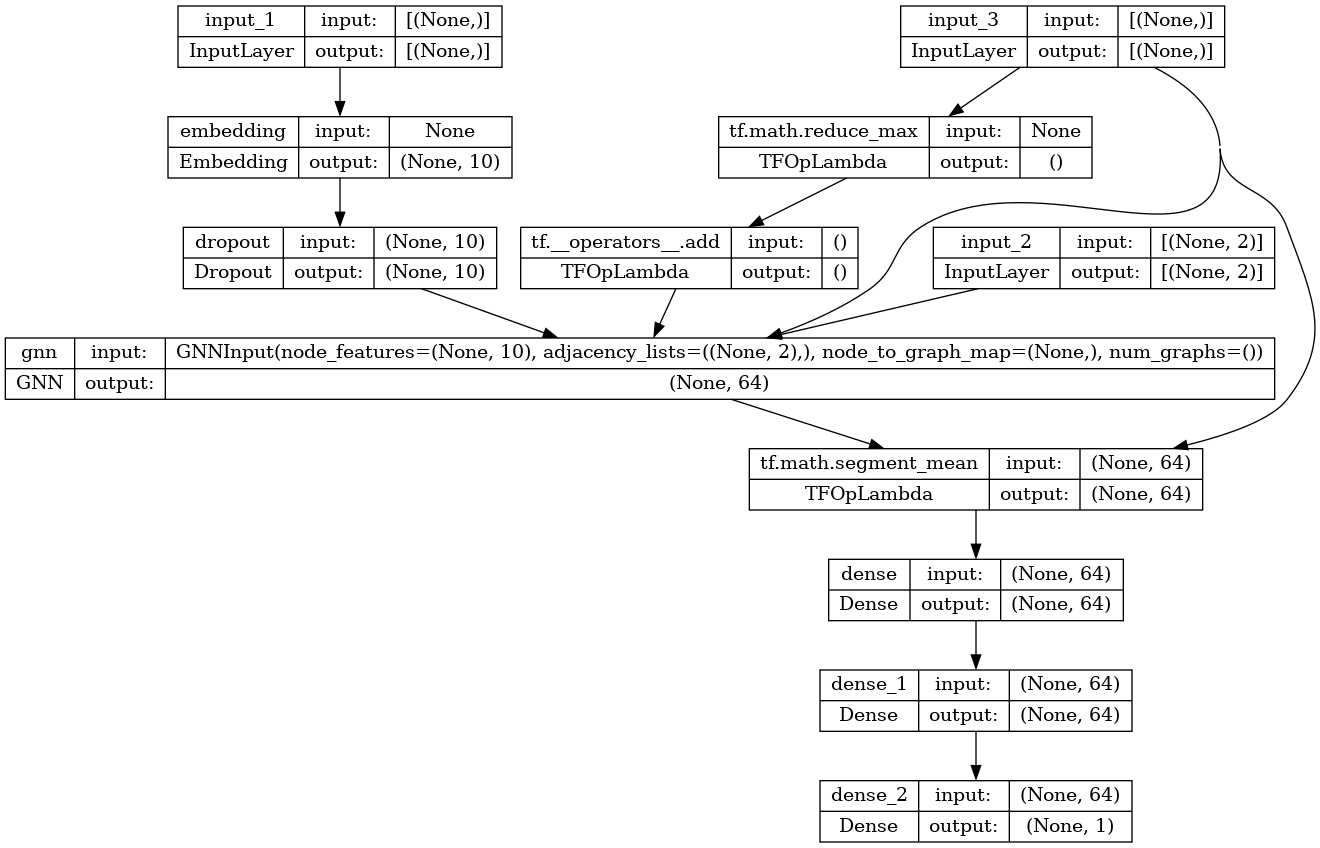

In [ ]:
# clear model creation session
backend.clear_session()
# create new model with trail hyperparameter
trail_1_model = create_model(message_calculation_class='GGNN', dense_intermediate_layer_activation='relu', hidden_dim=64, num_layers=3)
# plot trail model
plot_model(trail_1_model, show_shapes=True)

#### Train Model

In [ ]:
%%time
fit_model(model=trail_1_model, training_set=training_set, upsample=False)

Length of training set: 21270 and Length of validation set: 3754
Epoch 1/100
333/333 [==============================] - 16s 23ms/step - loss: 0.2163 - accuracy: 0.9512 - auc: 0.5873 - val_loss: 0.1855 - val_accuracy: 0.9521 - val_auc: 0.6246 - lr: 0.0010
Epoch 2/100
333/333 [==============================] - 6s 18ms/step - loss: 0.1861 - accuracy: 0.9512 - auc: 0.6581 - val_loss: 0.1846 - val_accuracy: 0.9523 - val_auc: 0.6530 - lr: 0.0010
Epoch 3/100
333/333 [==============================] - 6s 17ms/step - loss: 0.1847 - accuracy: 0.9512 - auc: 0.6716 - val_loss: 0.1858 - val_accuracy: 0.9521 - val_auc: 0.6787 - lr: 0.0010
Epoch 4/100
333/333 [==============================] - 5s 16ms/step - loss: 0.1835 - accuracy: 0.9512 - auc: 0.6768 - val_loss: 0.1786 - val_accuracy: 0.9513 - val_auc: 0.7051 - lr: 0.0010
Epoch 5/100
333/333 [==============================] - 5s 16ms/step - loss: 0.1798 - accuracy: 0.9512 - auc: 0.7044 - val_loss: 0.1675 - val_accuracy: 0.9550 - val_auc: 0.7370 - 

#### Display Training Curves

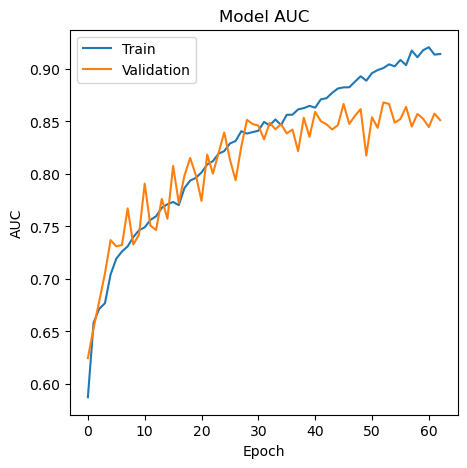

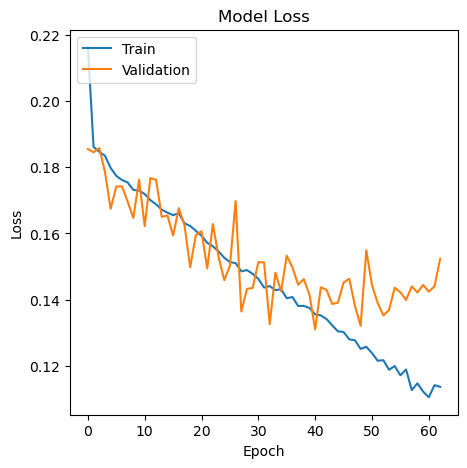

In [ ]:
# display learning curves auc and val auc on each epochs - loss and val loss on each epochs
display_curves(trail_1_model.history)

#### Save Prediction Submission

In [ ]:
# save test prediction as submission to submit in kaggle.
save_submission(trail_1_model, testing_set, 1)

771/771 [==============================] - 4s 5ms/step


#### Observation

Here I tried GNN with message_calculation_class = 'GGNN', dense_intermediate_layer_activation = 'relu', hidden_dim = '64', num_layers = '3' and without upsampling.

The training auc reaches 91% and validation auc reaches 86%.

Which shows an imporvment in both the training auc and the validation auc from the other parameters values.

Note: 
- I tired num_layers = ['12', '4'] but it wasn't that good so I tried the common value '3'. 
- I tried also hidden_dim = ['16', '32', '128'] but the auc was low and slow in learning.
- I tried dense_intermediate_layer_activation = ['tanh'] and also the training was low and slow.
- I tried global_exchange_mode = ['mean', 'mlp'] but ['gru'] was better.

I could do like 6 or more trial with these 😅. but I prefere trying different message passing mechanisms and ['with', 'without'] upsampling.

---

---

### Trial 2
GNN with message_calculation_class = 'GGNN' and dense_intermediate_layer_activation = 'relu' and hidden_dim = '64' and num_layers = '3' and with upsampling.

#### Create Model

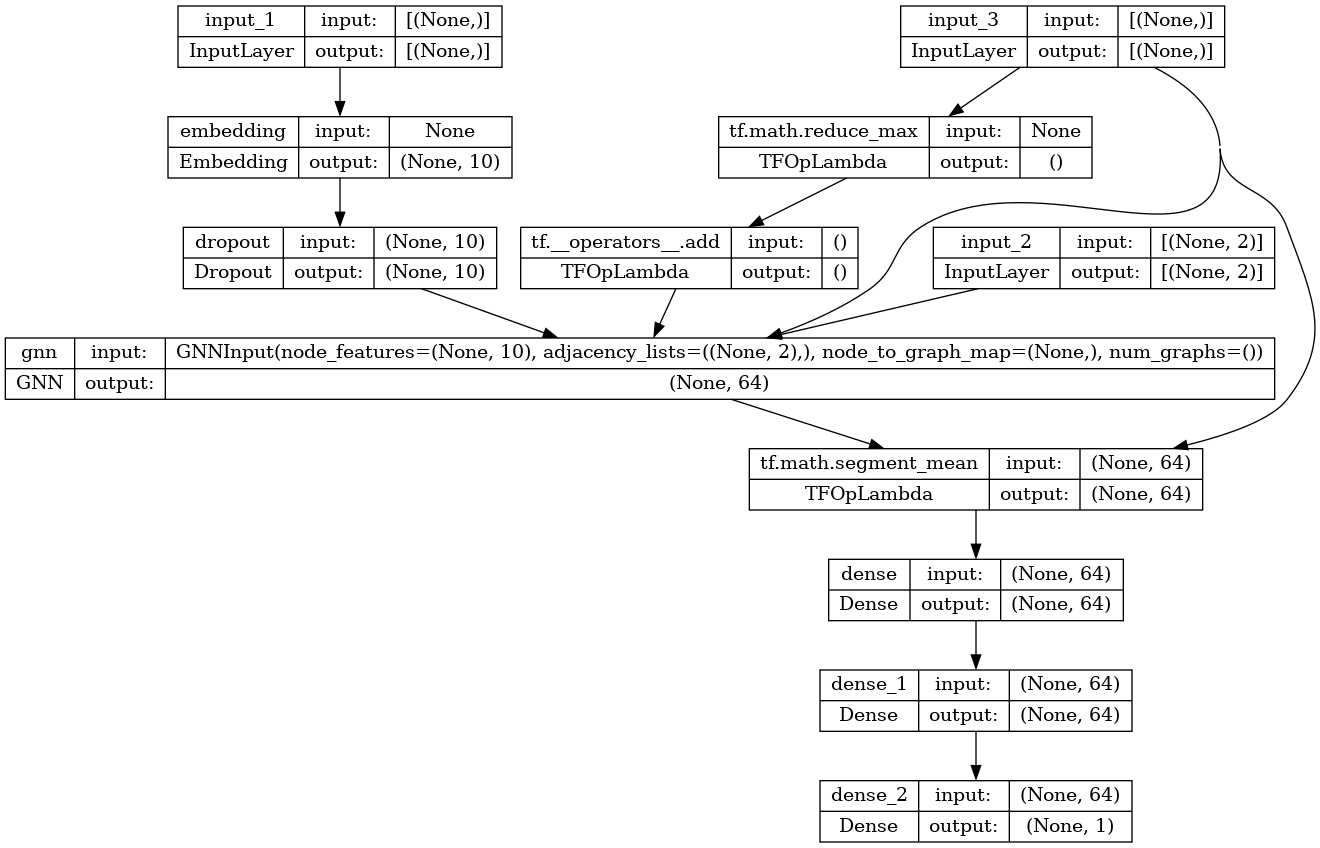

In [ ]:
# clear model creation session
backend.clear_session()
# create new model with trail hyperparameter
trail_2_model = create_model(message_calculation_class='GGNN', dense_intermediate_layer_activation='relu', hidden_dim=64, num_layers=3)
# plot trail model
plot_model(trail_2_model, show_shapes=True)

#### Train Model

In [ ]:
%%time
fit_model(model=trail_2_model, training_set=training_set, upsample=True)

Length of training set: 40470 and Length of validation set: 7142
Epoch 1/100
633/633 [==============================] - 18s 19ms/step - loss: 0.6409 - accuracy: 0.6285 - auc: 0.6769 - val_loss: 0.6119 - val_accuracy: 0.6698 - val_auc: 0.7347 - lr: 0.0010
Epoch 2/100
633/633 [==============================] - 10s 15ms/step - loss: 0.6050 - accuracy: 0.6773 - auc: 0.7290 - val_loss: 0.6098 - val_accuracy: 0.6633 - val_auc: 0.7537 - lr: 0.0010
Epoch 3/100
633/633 [==============================] - 10s 16ms/step - loss: 0.5905 - accuracy: 0.6938 - auc: 0.7471 - val_loss: 0.5700 - val_accuracy: 0.7110 - val_auc: 0.7749 - lr: 0.0010
Epoch 4/100
633/633 [==============================] - 10s 16ms/step - loss: 0.5671 - accuracy: 0.7130 - auc: 0.7765 - val_loss: 0.5265 - val_accuracy: 0.7571 - val_auc: 0.8254 - lr: 0.0010
Epoch 5/100
633/633 [==============================] - 10s 16ms/step - loss: 0.5292 - accuracy: 0.7423 - auc: 0.8129 - val_loss: 0.5264 - val_accuracy: 0.7452 - val_auc: 0.837

#### Display Training Curves

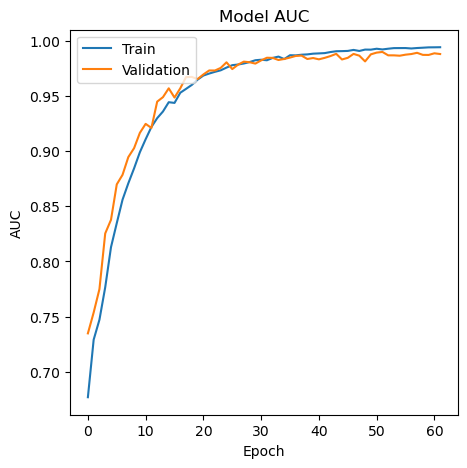

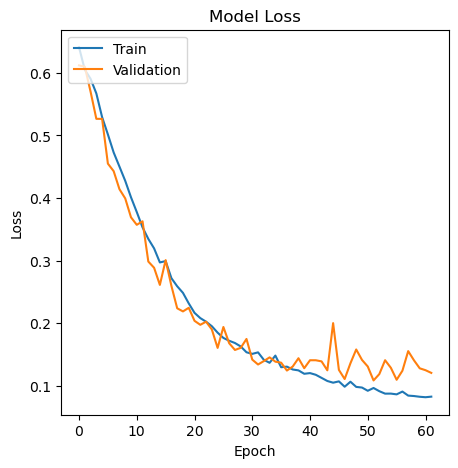

In [ ]:
# display learning curves auc and val auc on each epochs - loss and val loss on each epochs
display_curves(trail_2_model.history)

#### Save Prediction Submission

In [ ]:
# save test prediction as submission to submit in kaggle.
save_submission(trail_2_model, testing_set, 2)

771/771 [==============================] - 4s 4ms/step


#### Observation

Here I tried GNN with message_calculation_class = 'GGNN', dense_intermediate_layer_activation = 'relu', hidden_dim = '64', num_layers = '3' and with upsampling.

The training auc reaches 97% and validation auc reaches 98% but the public score on kaggle reaches 86%.

Which shows an imporvment in both the training auc and the validation auc from the previous trial without upsample.

---

---

### Trial 3
GNN with message_calculation_class = 'RGCN' and dense_intermediate_layer_activation = 'tanh' and hidden_dim = '64' and num_layers = '3' and without upsampling.

#### Create Model

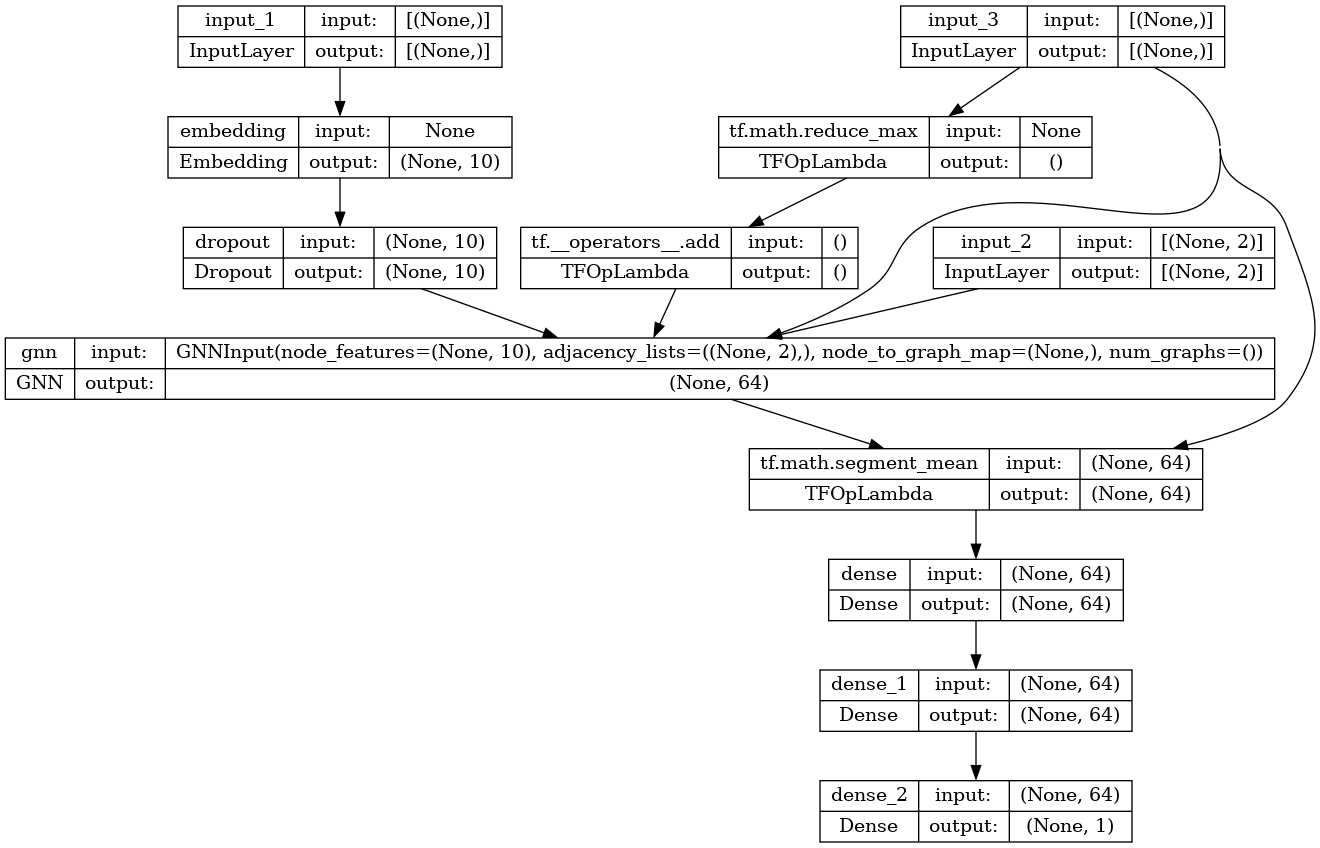

In [ ]:
# clear model creation session
backend.clear_session()
# create new model with trail hyperparameter
trail_3_model = create_model(message_calculation_class='RGCN', dense_intermediate_layer_activation='tanh', hidden_dim=64, num_layers=3)
# plot trail model
plot_model(trail_3_model, show_shapes=True)

#### Train Model

In [ ]:
%%time
fit_model(model=trail_3_model, training_set=training_set, upsample=False)

Length of training set: 21270 and Length of validation set: 3754
Epoch 1/100
333/333 [==============================] - 11s 19ms/step - loss: 0.2144 - accuracy: 0.9483 - auc: 0.5267 - val_loss: 0.1860 - val_accuracy: 0.9534 - val_auc: 0.6762 - lr: 0.0010
Epoch 2/100
333/333 [==============================] - 4s 13ms/step - loss: 0.1872 - accuracy: 0.9505 - auc: 0.6484 - val_loss: 0.1744 - val_accuracy: 0.9534 - val_auc: 0.7129 - lr: 0.0010
Epoch 3/100
333/333 [==============================] - 4s 13ms/step - loss: 0.1846 - accuracy: 0.9506 - auc: 0.6689 - val_loss: 0.1822 - val_accuracy: 0.9518 - val_auc: 0.7218 - lr: 0.0010
Epoch 4/100
333/333 [==============================] - 5s 16ms/step - loss: 0.1842 - accuracy: 0.9506 - auc: 0.6684 - val_loss: 0.1709 - val_accuracy: 0.9531 - val_auc: 0.7449 - lr: 0.0010
Epoch 5/100
333/333 [==============================] - 5s 14ms/step - loss: 0.1832 - accuracy: 0.9506 - auc: 0.6791 - val_loss: 0.1739 - val_accuracy: 0.9521 - val_auc: 0.7434 - 

#### Display Training Curves

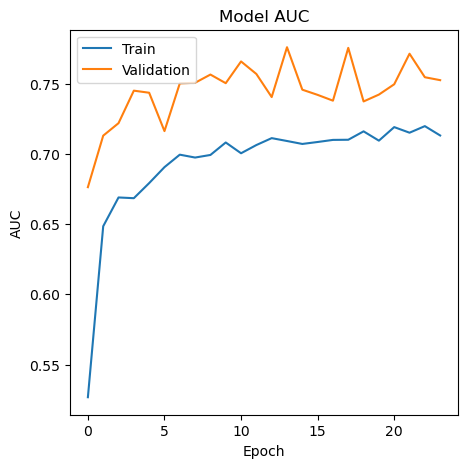

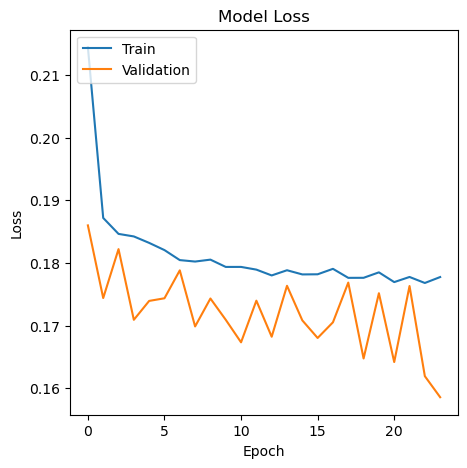

In [ ]:
# display learning curves auc and val auc on each epochs - loss and val loss on each epochs
display_curves(trail_3_model.history)

#### Save Prediction Submission

In [ ]:
# save test prediction as submission to submit in kaggle.
save_submission(trail_3_model, testing_set, 3)

771/771 [==============================] - 3s 4ms/step


#### Observation

Here I tried GNN with message_calculation_class = 'RGCN', dense_intermediate_layer_activation = 'tanh', hidden_dim = '64', num_layers = '3' and without upsampling.

The training auc reaches 71% and validation auc reaches 75%.

Which shows a decay in both the training auc and the validation auc from message passing = 'GGNN'.

---

---

### Trial 4
GNN with message_calculation_class = 'RGCN' and dense_intermediate_layer_activation = 'tanh' and hidden_dim = '64' and num_layers = '3' and with upsampling.

#### Create Model

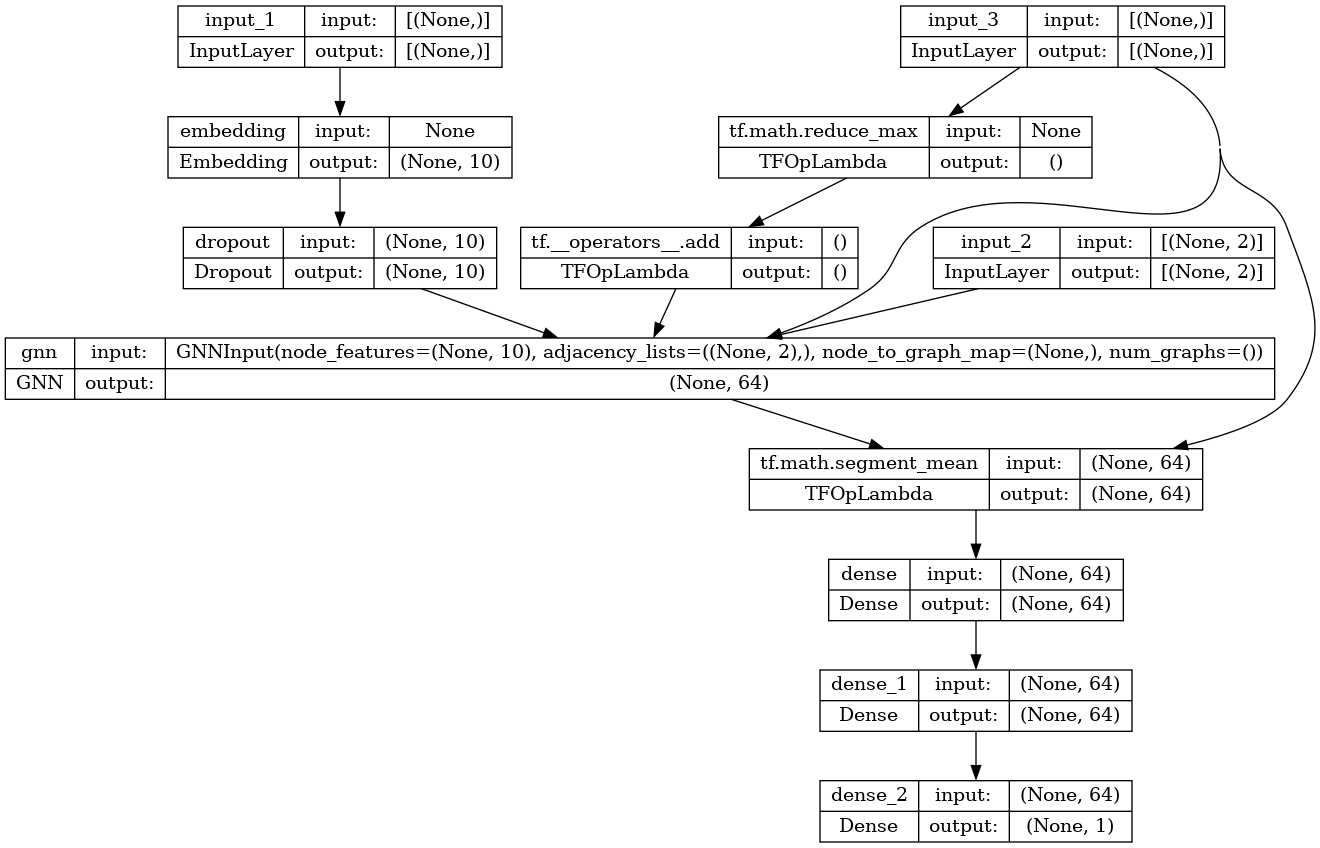

In [ ]:
# clear model creation session
backend.clear_session()
# create new model with trail hyperparameter
trail_4_model = create_model(message_calculation_class='RGCN', dense_intermediate_layer_activation='tanh', hidden_dim=64, num_layers=3)
# plot trail model
plot_model(trail_4_model, show_shapes=True)

#### Train Model

In [ ]:
%%time
fit_model(model=trail_4_model, training_set=training_set, upsample=True)

Length of training set: 40470 and Length of validation set: 7142
Epoch 1/100
633/633 [==============================] - 14s 15ms/step - loss: 0.6240 - accuracy: 0.6540 - auc: 0.7048 - val_loss: 0.6045 - val_accuracy: 0.6752 - val_auc: 0.7397 - lr: 0.0010
Epoch 2/100
633/633 [==============================] - 9s 14ms/step - loss: 0.6041 - accuracy: 0.6753 - auc: 0.7304 - val_loss: 0.6242 - val_accuracy: 0.6315 - val_auc: 0.7320 - lr: 0.0010
Epoch 3/100
633/633 [==============================] - 8s 13ms/step - loss: 0.5931 - accuracy: 0.6872 - auc: 0.7445 - val_loss: 0.5770 - val_accuracy: 0.7026 - val_auc: 0.7694 - lr: 0.0010
Epoch 4/100
633/633 [==============================] - 8s 13ms/step - loss: 0.5731 - accuracy: 0.7062 - auc: 0.7674 - val_loss: 0.5609 - val_accuracy: 0.7148 - val_auc: 0.7856 - lr: 0.0010
Epoch 5/100
633/633 [==============================] - 9s 15ms/step - loss: 0.5663 - accuracy: 0.7092 - auc: 0.7752 - val_loss: 0.5532 - val_accuracy: 0.7174 - val_auc: 0.7892 - 

#### Display Training Curves

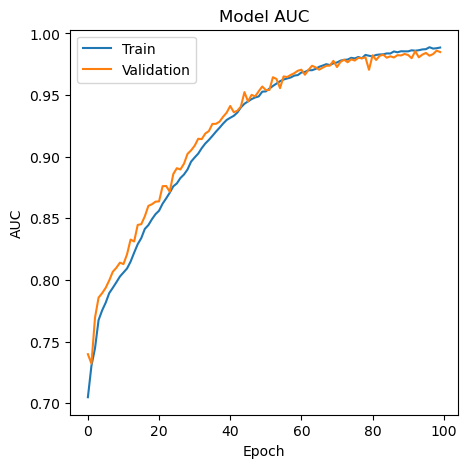

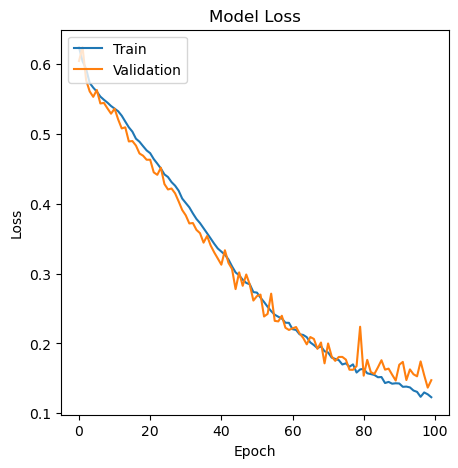

In [ ]:
# display learning curves auc and val auc on each epochs - loss and val loss on each epochs
display_curves(trail_4_model.history)

#### Save Prediction Submission

In [ ]:
# save test prediction as submission to submit in kaggle.
save_submission(trail_4_model, testing_set, 4)

771/771 [==============================] - 3s 4ms/step


#### Observation

Here I tried GNN with message_calculation_class = 'RGCN', dense_intermediate_layer_activation = 'tanh', hidden_dim = '64', num_layers = '3' and with upsampling.

The training auc reaches 98% and validation auc reaches 98% but the public score on kaggle reaches 82%.

Which shows an imporvment in both the training auc and the validation auc from the previous trial without upsample.

---

---

### Trial 5
GNN with message_calculation_class = 'RGIN' and dense_intermediate_layer_activation = 'relu' and hidden_dim = '64' and num_layers = '3' and without upsampling.

#### Create Model

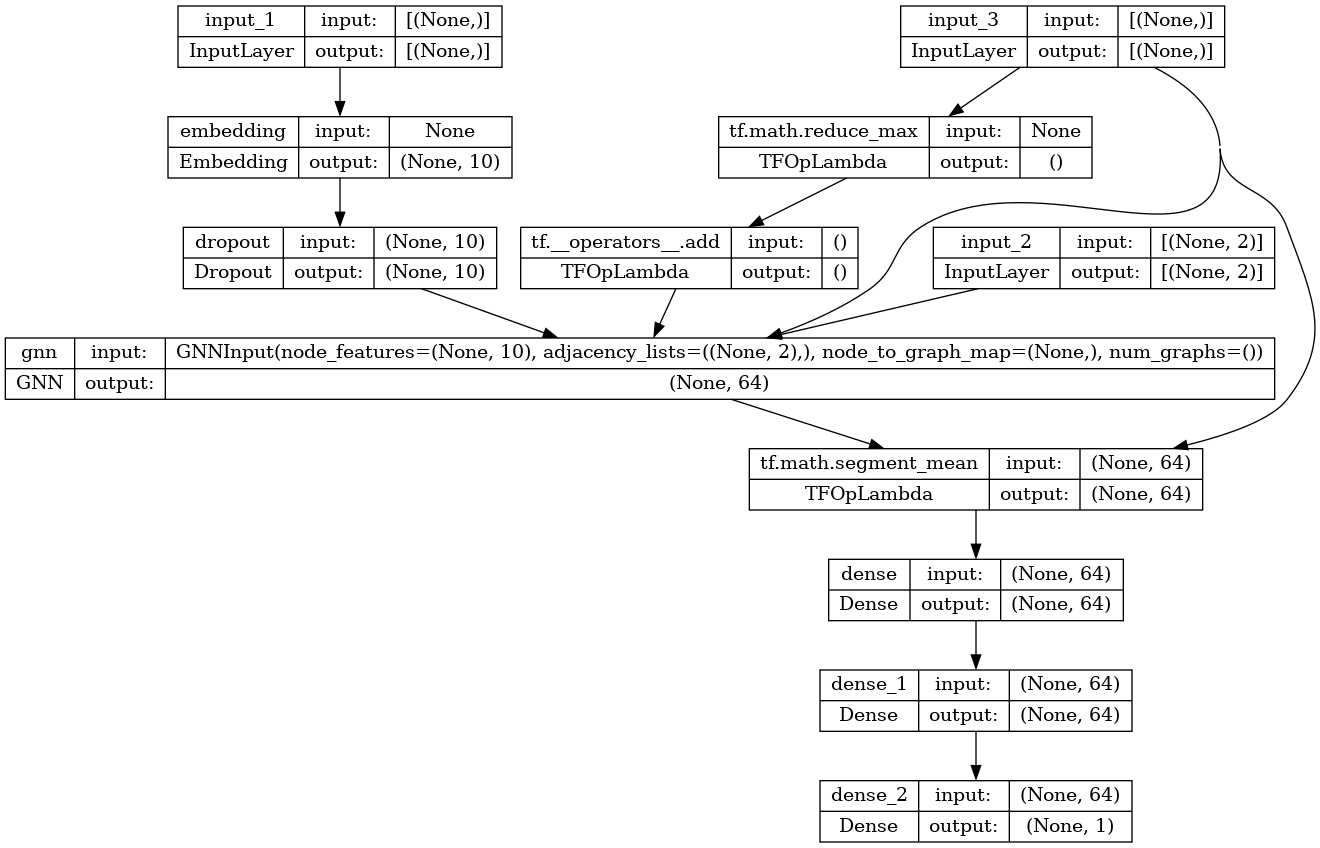

In [ ]:
# clear model creation session
backend.clear_session()
# create new model with trail hyperparameter
trail_5_model = create_model(message_calculation_class='RGIN', dense_intermediate_layer_activation='relu', hidden_dim=64, num_layers=4)
# plot trail model
plot_model(trail_5_model, show_shapes=True)

#### Train Model

In [ ]:
%%time
fit_model(model=trail_5_model, training_set=training_set, upsample=False)

Length of training set: 21270 and Length of validation set: 3754
Epoch 1/100
333/333 [==============================] - 13s 20ms/step - loss: 0.2574 - accuracy: 0.9484 - auc: 0.4642 - val_loss: 0.1810 - val_accuracy: 0.9534 - val_auc: 0.6420 - lr: 0.0010
Epoch 2/100
333/333 [==============================] - 5s 15ms/step - loss: 0.1876 - accuracy: 0.9510 - auc: 0.6612 - val_loss: 0.1809 - val_accuracy: 0.9526 - val_auc: 0.6822 - lr: 0.0010
Epoch 3/100
333/333 [==============================] - 6s 17ms/step - loss: 0.1836 - accuracy: 0.9510 - auc: 0.6810 - val_loss: 0.1732 - val_accuracy: 0.9542 - val_auc: 0.7083 - lr: 0.0010
Epoch 4/100
333/333 [==============================] - 5s 16ms/step - loss: 0.1808 - accuracy: 0.9510 - auc: 0.6983 - val_loss: 0.1788 - val_accuracy: 0.9515 - val_auc: 0.6822 - lr: 0.0010
Epoch 5/100
333/333 [==============================] - 5s 16ms/step - loss: 0.1789 - accuracy: 0.9509 - auc: 0.6992 - val_loss: 0.1651 - val_accuracy: 0.9558 - val_auc: 0.7052 - 

#### Display Training Curves

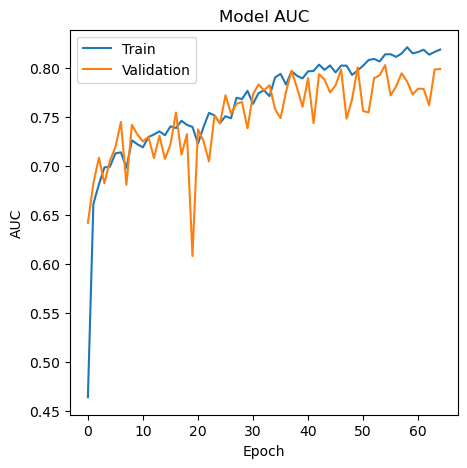

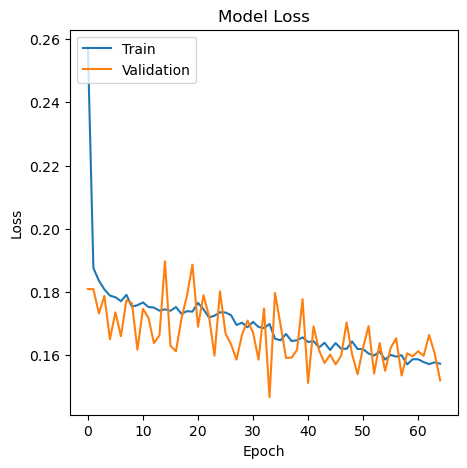

In [ ]:
# display learning curves auc and val auc on each epochs - loss and val loss on each epochs
display_curves(trail_5_model.history)

#### Save Prediction Submission

In [ ]:
# save test prediction as submission to submit in kaggle.
save_submission(trail_5_model, testing_set, 5)

771/771 [==============================] - 4s 5ms/step


#### Observation

Here I tried GNN with message_calculation_class = 'RGIN', dense_intermediate_layer_activation = 'relu', hidden_dim = '64', num_layers = '3' and without upsampling.

The training auc reaches 82% and validation auc reaches 80%.

Which shows a decay in both the training auc and the validation auc from message passing = 'GGNN' but an improvment from message passing = 'RGCN'.

---

---

### Trial 6
GNN with message_calculation_class = 'RGIN' and dense_intermediate_layer_activation = 'relu' and hidden_dim = '64' and num_layers = '3' and with upsampling.

#### Create Model

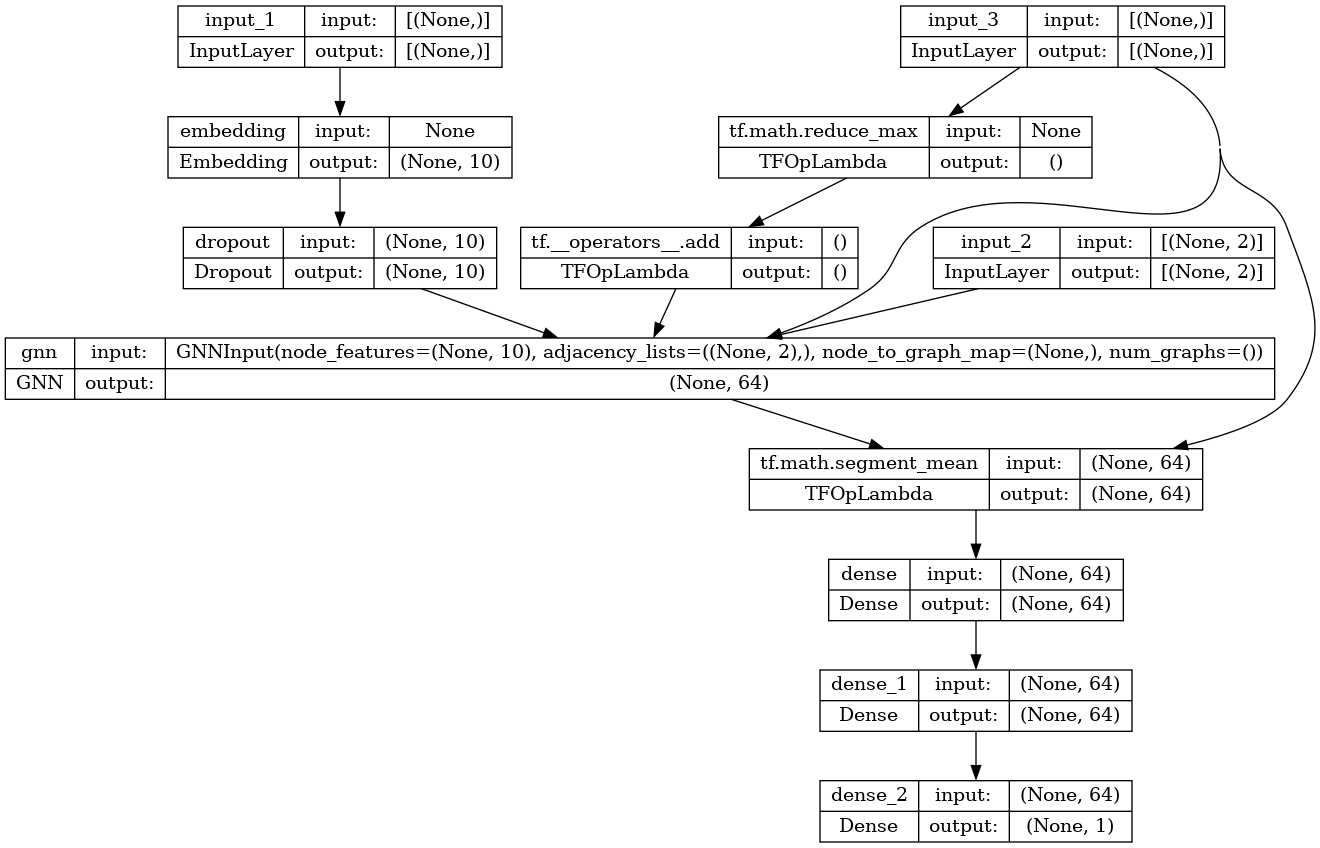

In [ ]:
# clear model creation session
backend.clear_session()
# create new model with trail hyperparameter
trail_6_model = create_model(message_calculation_class='RGIN', dense_intermediate_layer_activation='relu', hidden_dim=64, num_layers=4)
# plot trail model
plot_model(trail_6_model, show_shapes=True)

#### Train Model

In [ ]:
%%time
fit_model(model=trail_6_model, training_set=training_set, upsample=True)

Length of training set: 40470 and Length of validation set: 7142
Epoch 1/100
633/633 [==============================] - 18s 19ms/step - loss: 0.6362 - accuracy: 0.6387 - auc: 0.6858 - val_loss: 0.6037 - val_accuracy: 0.6816 - val_auc: 0.7358 - lr: 0.0010
Epoch 2/100
633/633 [==============================] - 10s 15ms/step - loss: 0.6017 - accuracy: 0.6855 - auc: 0.7337 - val_loss: 0.5874 - val_accuracy: 0.6955 - val_auc: 0.7531 - lr: 0.0010
Epoch 3/100
633/633 [==============================] - 11s 17ms/step - loss: 0.5890 - accuracy: 0.6951 - auc: 0.7505 - val_loss: 0.5769 - val_accuracy: 0.7046 - val_auc: 0.7682 - lr: 0.0010
Epoch 4/100
633/633 [==============================] - 10s 15ms/step - loss: 0.5712 - accuracy: 0.7083 - auc: 0.7704 - val_loss: 0.5601 - val_accuracy: 0.7146 - val_auc: 0.7878 - lr: 0.0010
Epoch 5/100
633/633 [==============================] - 10s 16ms/step - loss: 0.5619 - accuracy: 0.7159 - auc: 0.7816 - val_loss: 0.5527 - val_accuracy: 0.7211 - val_auc: 0.792

#### Display Training Curves

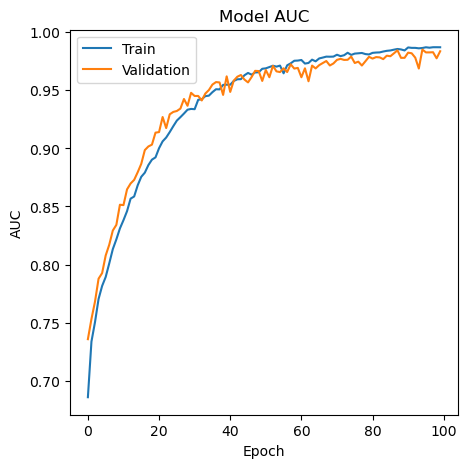

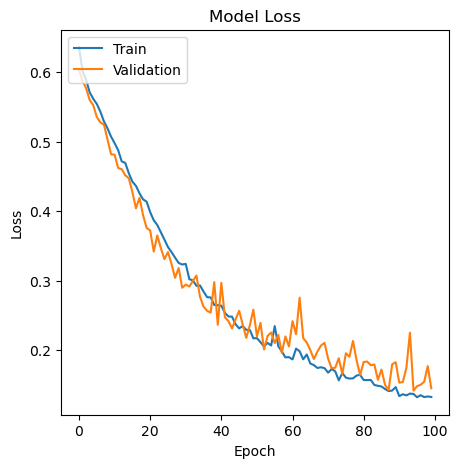

In [ ]:
# display learning curves auc and val auc on each epochs - loss and val loss on each epochs
display_curves(trail_6_model.history)

#### Save Prediction Submission

In [ ]:
# save test prediction as submission to submit in kaggle.
save_submission(trail_6_model, testing_set, 6)

771/771 [==============================] - 4s 5ms/step


#### Observation

Here I tried GNN with message_calculation_class = 'RGCN', dense_intermediate_layer_activation = 'tanh', hidden_dim = '64', num_layers = '3' and with upsampling.

The training auc reaches 98% and validation auc reaches 98% but the public score on kaggle reaches 81%.

Which shows an imporvment in both the training auc and the validation auc from the previous trial without upsample, and almost the same progress like message passing = 'RGIN'

---

---

### Trial 7
GNN with message_calculation_class = 'GNN-Edge-MLP' and dense_intermediate_layer_activation = 'tanh' and hidden_dim = '64' and num_layers = '3' and global_exchange_mode = 'mlp' and without upsampling.

#### Create Model

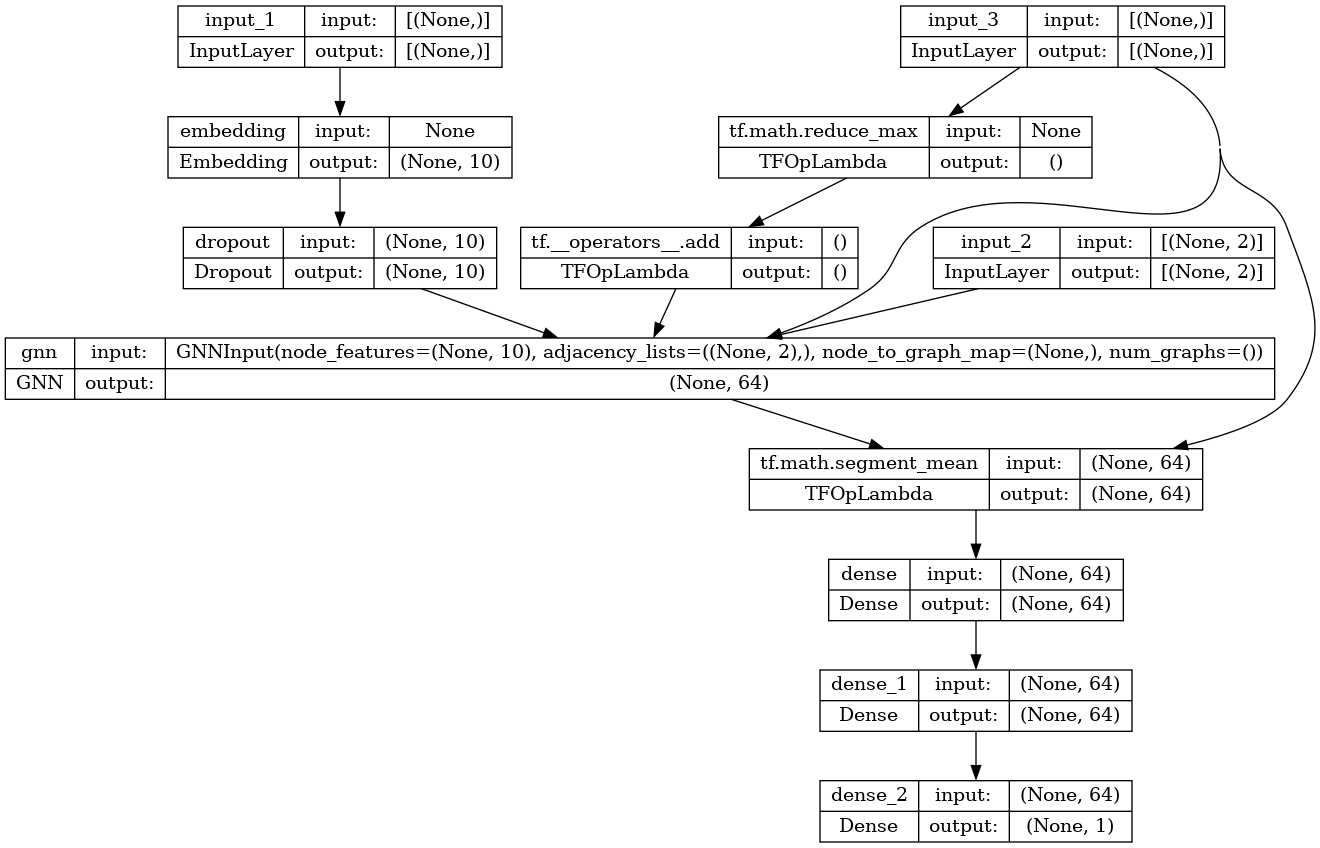

In [ ]:
# clear model creation session
backend.clear_session()
# create new model with trail hyperparameter
trail_7_model = create_model(message_calculation_class='GNN_Edge_MLP', dense_intermediate_layer_activation='tanh', hidden_dim=64, num_layers=3, global_exchange_mode='mlp')
# plot trail model
plot_model(trail_7_model, show_shapes=True)

#### Train Model

In [ ]:
%%time
fit_model(model=trail_7_model, training_set=training_set, upsample=False)

Length of training set: 21270 and Length of validation set: 3754
Epoch 1/100
333/333 [==============================] - 10s 16ms/step - loss: 0.2241 - accuracy: 0.9490 - auc: 0.5140 - val_loss: 0.1819 - val_accuracy: 0.9550 - val_auc: 0.5831 - lr: 0.0010
Epoch 2/100
333/333 [==============================] - 5s 15ms/step - loss: 0.1866 - accuracy: 0.9507 - auc: 0.6668 - val_loss: 0.1783 - val_accuracy: 0.9542 - val_auc: 0.6494 - lr: 0.0010
Epoch 3/100
333/333 [==============================] - 5s 14ms/step - loss: 0.1841 - accuracy: 0.9502 - auc: 0.6899 - val_loss: 0.1755 - val_accuracy: 0.9547 - val_auc: 0.6725 - lr: 0.0010
Epoch 4/100
333/333 [==============================] - 5s 14ms/step - loss: 0.1819 - accuracy: 0.9503 - auc: 0.7080 - val_loss: 0.1756 - val_accuracy: 0.9552 - val_auc: 0.6640 - lr: 0.0010
Epoch 5/100
333/333 [==============================] - 5s 15ms/step - loss: 0.1831 - accuracy: 0.9499 - auc: 0.7008 - val_loss: 0.1788 - val_accuracy: 0.9539 - val_auc: 0.6764 - 

#### Display Training Curves

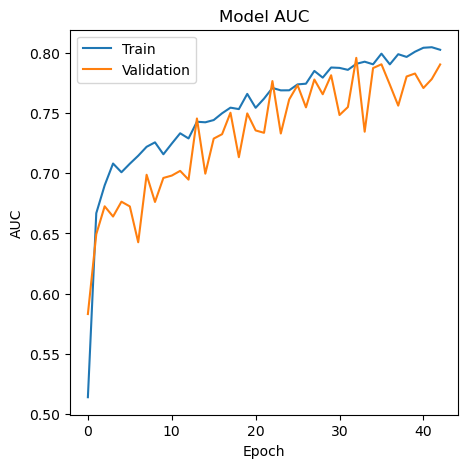

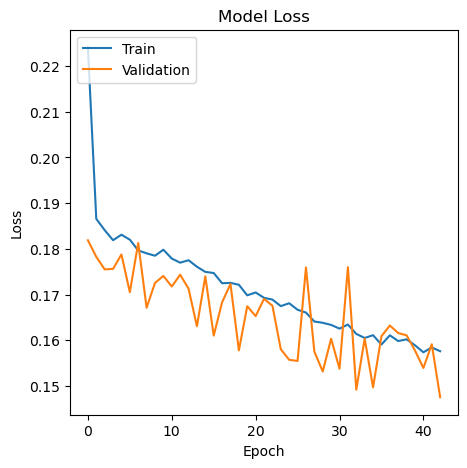

In [ ]:
# display learning curves auc and val auc on each epochs - loss and val loss on each epochs
display_curves(trail_7_model.history)

#### Save Prediction Submission

In [ ]:
# save test prediction as submission to submit in kaggle.
save_submission(trail_7_model, testing_set, 7)

771/771 [==============================] - 3s 4ms/step


#### Observation

Here I tried GNN with message_calculation_class = 'GNN-Edge-MLP' and dense_intermediate_layer_activation = 'tanh' and hidden_dim = '64' and num_layers = '3' and global_exchange_mode = 'mlp' and without upsampling. but the training progress was not that good.

The training auc reaches 80% and validation auc reaches 79%.

Which shows a decay in both the training auc and the validation auc from message passing = 'GGNN' and almost same progress like message passing = 'RGIN'.

---

---

### Trial 8
GNN with message_calculation_class = 'GNN-Edge-MLP' and dense_intermediate_layer_activation = 'tanh' and hidden_dim = '64' and num_layers = '3' and global_exchange_mode = 'mlp' and with upsampling.

#### Create Model

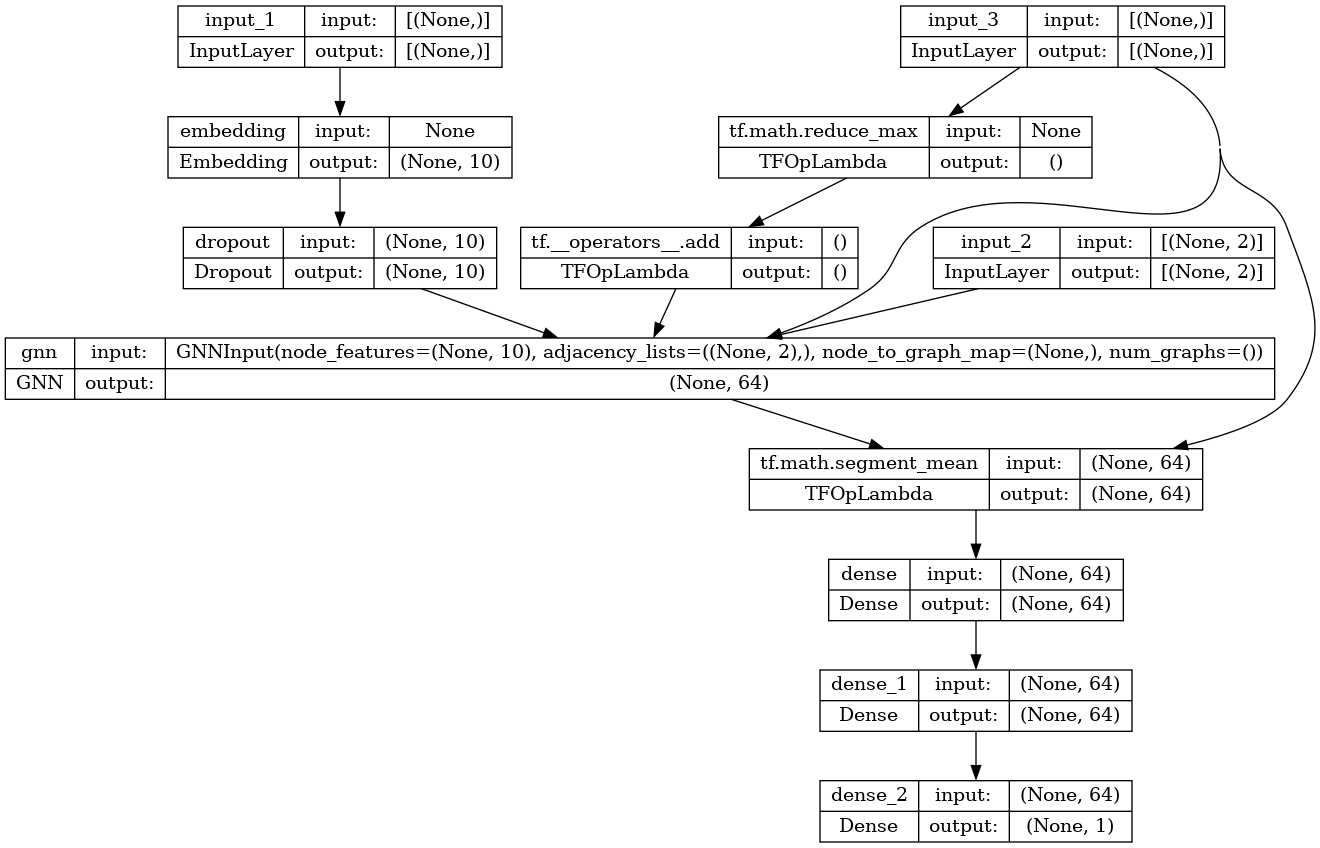

In [ ]:
# clear model creation session
backend.clear_session()
# create new model with trail hyperparameter
trail_8_model = create_model(message_calculation_class='GNN_Edge_MLP', dense_intermediate_layer_activation='tanh', hidden_dim=64, num_layers=3, global_exchange_mode='mlp')
# plot trail model
plot_model(trail_8_model, show_shapes=True)

#### Train Model

In [ ]:
%%time
fit_model(model=trail_8_model, training_set=training_set, upsample=True)

Length of training set: 40470 and Length of validation set: 7142
Epoch 1/100
633/633 [==============================] - 15s 16ms/step - loss: 0.6241 - accuracy: 0.6521 - auc: 0.7083 - val_loss: 0.6109 - val_accuracy: 0.6738 - val_auc: 0.7389 - lr: 0.0010
Epoch 2/100
633/633 [==============================] - 9s 14ms/step - loss: 0.5957 - accuracy: 0.6853 - auc: 0.7432 - val_loss: 0.5760 - val_accuracy: 0.6985 - val_auc: 0.7662 - lr: 0.0010
Epoch 3/100
633/633 [==============================] - 9s 14ms/step - loss: 0.5716 - accuracy: 0.7053 - auc: 0.7715 - val_loss: 0.5505 - val_accuracy: 0.7230 - val_auc: 0.7973 - lr: 0.0010
Epoch 4/100
633/633 [==============================] - 9s 14ms/step - loss: 0.5571 - accuracy: 0.7198 - auc: 0.7864 - val_loss: 0.5432 - val_accuracy: 0.7293 - val_auc: 0.8017 - lr: 0.0010
Epoch 5/100
633/633 [==============================] - 9s 14ms/step - loss: 0.5400 - accuracy: 0.7336 - auc: 0.8032 - val_loss: 0.5169 - val_accuracy: 0.7523 - val_auc: 0.8243 - 

#### Display Training Curves

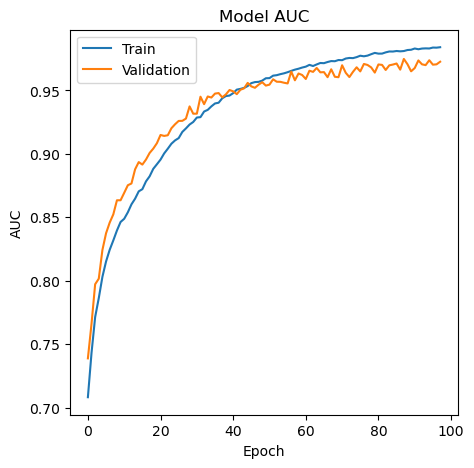

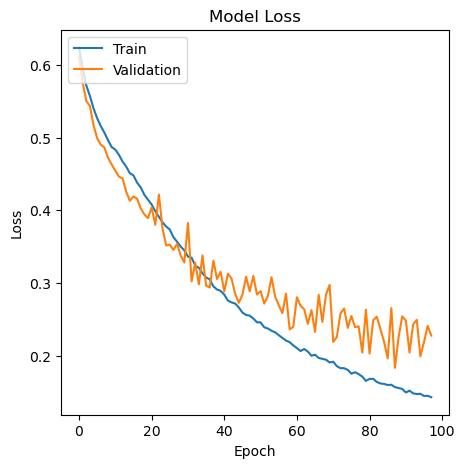

In [ ]:
# display learning curves auc and val auc on each epochs - loss and val loss on each epochs
display_curves(trail_8_model.history)

#### Save Prediction Submission

In [ ]:
# save test prediction as submission to submit in kaggle.
save_submission(trail_8_model, testing_set, 8)

771/771 [==============================] - 3s 4ms/step


#### Observation

Here I tried GNN with message_calculation_class = 'GNN-Edge-MLP' and dense_intermediate_layer_activation = 'tanh' and hidden_dim = '64' and num_layers = '3' and global_exchange_mode = 'mlp' and with upsampling.

The training auc reaches 98% and validation auc reaches 97% but the public score on kaggle reaches 82%.

Which shows an imporvment in both the training auc and the validation auc from the previous trial without upsample, and almost the same progress like message passing = 'RGCN'

---

---

### Trial 9
GNN with message_calculation_class = 'GNN-FiLM' and dense_intermediate_layer_activation = 'relu' and hidden_dim = '64' and num_layers = '3' and global_exchange_mode = 'mlp' and with upsampling.

#### Create Model

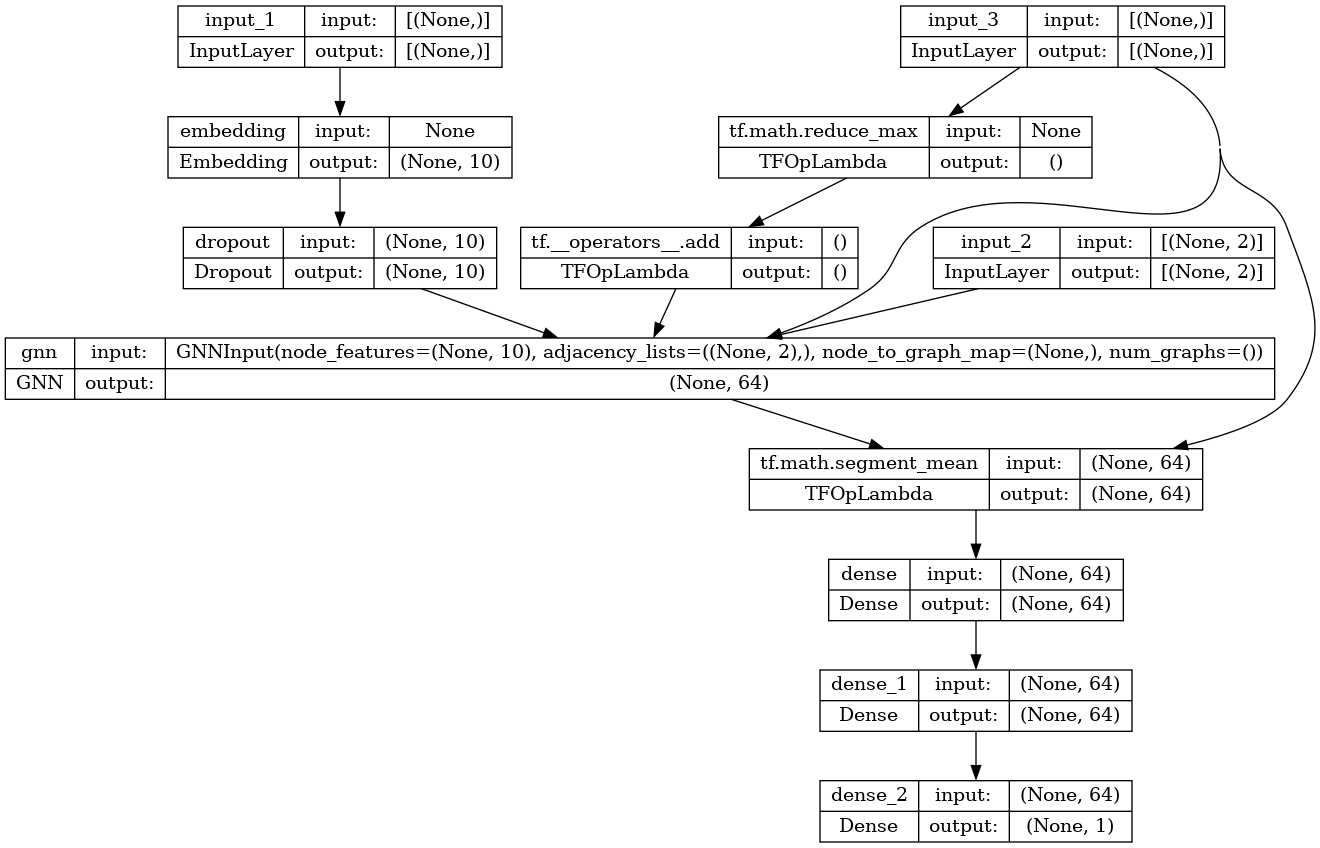

In [ ]:
# clear model creation session
backend.clear_session()
# create new model with trail hyperparameter
trail_9_model = create_model(message_calculation_class='GNN_FiLM', dense_intermediate_layer_activation='relu', hidden_dim=64, num_layers=3, global_exchange_mode='mlp')
# plot trail model
plot_model(trail_9_model, show_shapes=True)

#### Train Model

In [ ]:
%%time
fit_model(model=trail_9_model, training_set=training_set, upsample=True)

Length of training set: 40470 and Length of validation set: 7142
Epoch 1/100
633/633 [==============================] - 17s 18ms/step - loss: 0.6438 - accuracy: 0.6216 - auc: 0.6695 - val_loss: 0.6034 - val_accuracy: 0.6703 - val_auc: 0.7333 - lr: 0.0010
Epoch 2/100
633/633 [==============================] - 10s 16ms/step - loss: 0.5803 - accuracy: 0.6973 - auc: 0.7576 - val_loss: 0.5648 - val_accuracy: 0.7169 - val_auc: 0.7821 - lr: 0.0010
Epoch 3/100
633/633 [==============================] - 11s 17ms/step - loss: 0.5548 - accuracy: 0.7225 - auc: 0.7846 - val_loss: 0.5514 - val_accuracy: 0.7258 - val_auc: 0.7999 - lr: 0.0010
Epoch 4/100
633/633 [==============================] - 10s 16ms/step - loss: 0.5382 - accuracy: 0.7350 - auc: 0.8030 - val_loss: 0.5440 - val_accuracy: 0.7391 - val_auc: 0.8144 - lr: 0.0010
Epoch 5/100
633/633 [==============================] - 10s 16ms/step - loss: 0.5371 - accuracy: 0.7394 - auc: 0.8087 - val_loss: 0.5192 - val_accuracy: 0.7501 - val_auc: 0.826

#### Display Training Curves

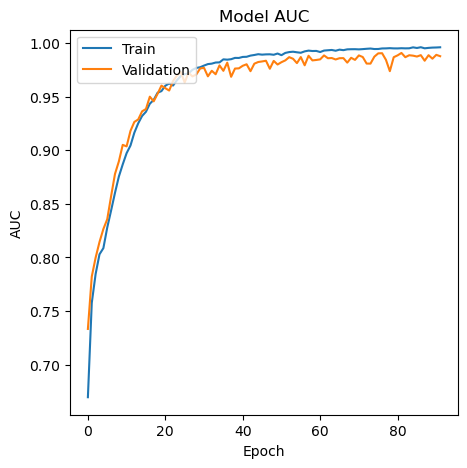

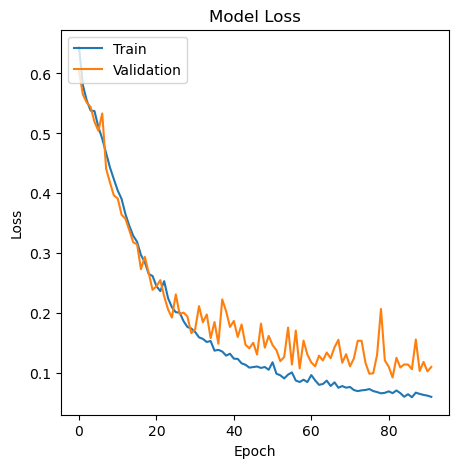

In [ ]:
# display learning curves auc and val auc on each epochs - loss and val loss on each epochs
display_curves(trail_9_model.history)

#### Save Prediction Submission

In [ ]:
# save test prediction as submission to submit in kaggle.
save_submission(trail_9_model, testing_set, 9)

771/771 [==============================] - 4s 4ms/step


#### Observation

Here I tried GNN with message_calculation_class = 'GNN_FiLM' and dense_intermediate_layer_activation = 'relu' and hidden_dim = '64' and num_layers = '3' and global_exchange_mode = 'mlp' and with upsampling.

The training auc reaches 99% and validation auc reaches 99% but the public score on kaggle reaches 86%.

Which shows an imporvment in both the training auc and the validation auc from the previous trials with or without upsample.

---

---

### Trial 10
GNN with message_calculation_class = 'GNN-FiLM' and dense_intermediate_layer_activation = 'relu' and hidden_dim = '64' and num_layers = '3' and global_exchange_mode = 'gru' and with upsampling.

#### Create Model

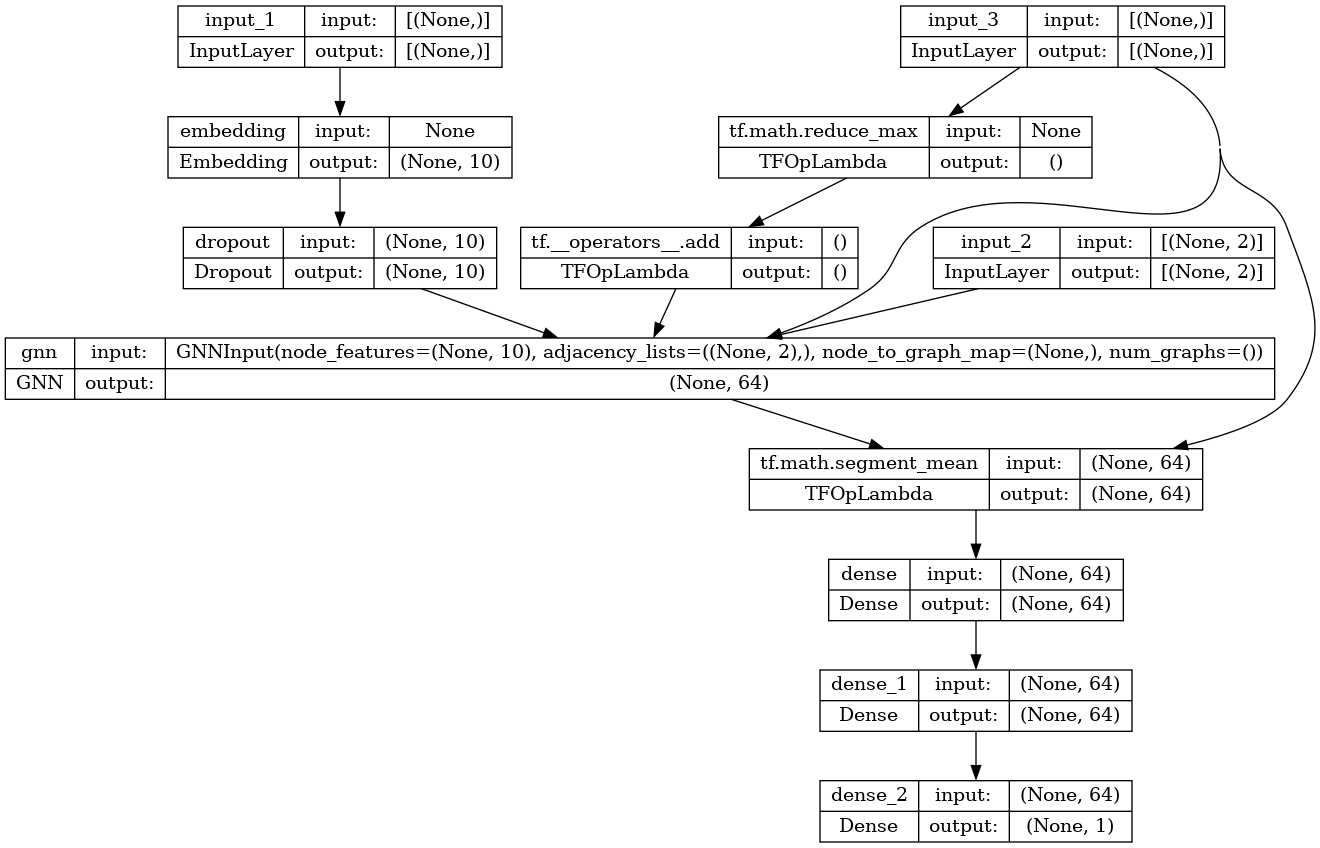

In [ ]:
# clear model creation session
backend.clear_session()
# create new model with trail hyperparameter
trail_10_model = create_model(message_calculation_class='GNN_FiLM', dense_intermediate_layer_activation='relu', hidden_dim=64, num_layers=3)
# plot trail model
plot_model(trail_10_model, show_shapes=True)

#### Train Model

In [ ]:
%%time
fit_model(model=trail_10_model, training_set=training_set, upsample=True)

Length of training set: 40470 and Length of validation set: 7142
Epoch 1/100
633/633 [==============================] - 18s 19ms/step - loss: 0.6369 - accuracy: 0.6304 - auc: 0.6849 - val_loss: 0.5810 - val_accuracy: 0.7027 - val_auc: 0.7633 - lr: 0.0010
Epoch 2/100
633/633 [==============================] - 11s 17ms/step - loss: 0.5766 - accuracy: 0.7024 - auc: 0.7656 - val_loss: 0.5540 - val_accuracy: 0.7236 - val_auc: 0.7905 - lr: 0.0010
Epoch 3/100
633/633 [==============================] - 11s 17ms/step - loss: 0.5555 - accuracy: 0.7204 - auc: 0.7883 - val_loss: 0.5367 - val_accuracy: 0.7432 - val_auc: 0.8065 - lr: 0.0010
Epoch 4/100
633/633 [==============================] - 11s 17ms/step - loss: 0.5299 - accuracy: 0.7417 - auc: 0.8121 - val_loss: 0.5269 - val_accuracy: 0.7429 - val_auc: 0.8157 - lr: 0.0010
Epoch 5/100
633/633 [==============================] - 11s 18ms/step - loss: 0.5153 - accuracy: 0.7479 - auc: 0.8233 - val_loss: 0.5093 - val_accuracy: 0.7502 - val_auc: 0.836

#### Display Training Curves

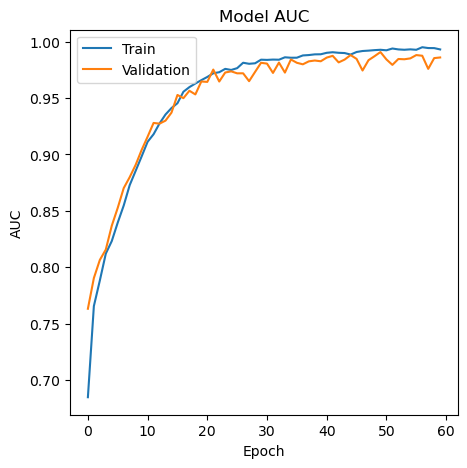

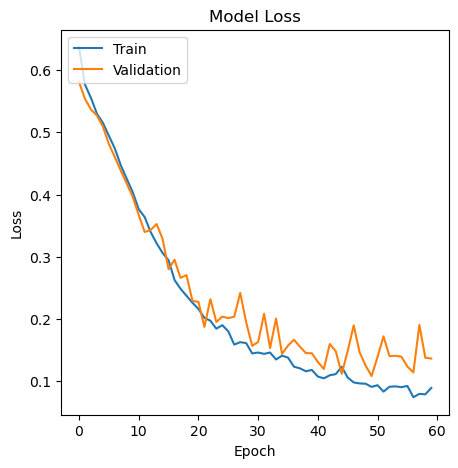

In [ ]:
# display learning curves auc and val auc on each epochs - loss and val loss on each epochs
display_curves(trail_10_model.history)

#### Save Prediction Submission

In [ ]:
# save test prediction as submission to submit in kaggle.
save_submission(trail_10_model, testing_set, 10)

771/771 [==============================] - 4s 5ms/step


#### Observation

Here I tried GNN with message_calculation_class = 'GNN_FiLM' and dense_intermediate_layer_activation = 'relu' and hidden_dim = '64' and num_layers = '3' and global_exchange_mode = 'gru' and with upsampling.

The training auc reaches 99% and validation auc reaches 99% but the public score on kaggle reaches 88% which is my best score 😊👌❤️

Which shows an imporvment in both the training auc and the validation auc from the previous trials with or without upsample.

---

---

### General Note

I tired many parameter values on each trail to get these training and validation AUCs but the AUC vary each time, I say that because I get better values many times before.